# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (urti), upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [14]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
import io
import sys
from contextlib import redirect_stdout
%matplotlib inline

In [15]:
#os.chdir("..")
current_working_dir = os.getcwd()
# print(current_working_dir)

# !python --version
# import sklearn
# print(sklearn.__version__)
# import lifelines
# print(lifelines.__version__)

In [16]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [17]:
# def makeFilePath(pathFromWorkspace, fileName):
#     workingdir = "/workspace/" if (os.name != "nt") else ""
#     filepath = workingdir+pathFromWorkspace+fileName

#     return filepath

In [18]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [19]:
def create_lineplot(data, var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    a.Freq = a.Freq /1000
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count in 1000 patients')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [20]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [21]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

## 1- Data Preparation

In [22]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation.csv.gz')
data.shape

(200000, 79)

In [23]:
data.describe(include='all')

,deregistered_date,died_date,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,admitted_date,urti_date_1,urti_date_2,...,hemiplegia_comor,hiv_comor,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id
count,10000,20000,150000,20000,20000,20000,20000,60000,20000,20000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05
unique,1210,695,40,40,40,13,13,1210,1210,1210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2020-07-05,2022-04-15,2020-07,2021-06,2020-06,2018-03,2018-12,2021-03-18,2021-02-17,2020-07-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,19,178,4012,556,559,1761,1724,72,29,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,9.994194e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,5.767260e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000372e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.982130e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500024e+06


### 1-2- Additional variables
#### 1-2-1- Calculating CHarlson Comorbidity Index
Based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [24]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [25]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    # if data.iat[idx, col4] == 1: # heart_failure_comor############################
    #     n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia#########################################
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma#########################################
    #    n=n+2

    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3

    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

2.0     26364
3.0     25753
4.0     23906
1.0     23588
0.0     18937
5.0     17597
6.0     15866
7.0     12473
8.0      9665
9.0      7628
10.0     6092
11.0     4177
12.0     2985
13.0     1933
14.0     1197
15.0      726
16.0      513
17.0      270
18.0      157
19.0       95
20.0       40
21.0       27
22.0        5
23.0        4
24.0        2
Name: CCI, dtype: int64

#### 1-2-2- Calculating all meds except abs

In [26]:
#generate meds_noabs in the one month before
data['meds_nonabs'] = data['all_meds'] - data['antibacterial_brit']

# assign zero for any row with negative values which could be the case because of using dummy data and/or the inconsistency of the two codelists of all_meds and antibacterial_brit
data['meds_nonabs'][data['meds_nonabs'] < 0] = 0

data['meds_nonabs'].value_counts()
# data[['all_meds_one_month', 'antibacterial_brit_one_month', 'meds_nonabs']]

0    132877
2     22597
3     18600
1     17481
4      7275
5      1105
6        65
Name: meds_nonabs, dtype: int64

### 1-3- Handling variables with missing values
#### 1-3-1- Drop variables with many missing values
We drop colmns with more than 50 percent missing values as they may not be usable in the prediction model, nor they can be imputed properly.

In [27]:
#dropping any variable with more than 50 percent missing values
perc = 50.0
data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']] = data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']].loc[:, data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']].isnull().mean() < perc]
data.shape

(200000, 81)

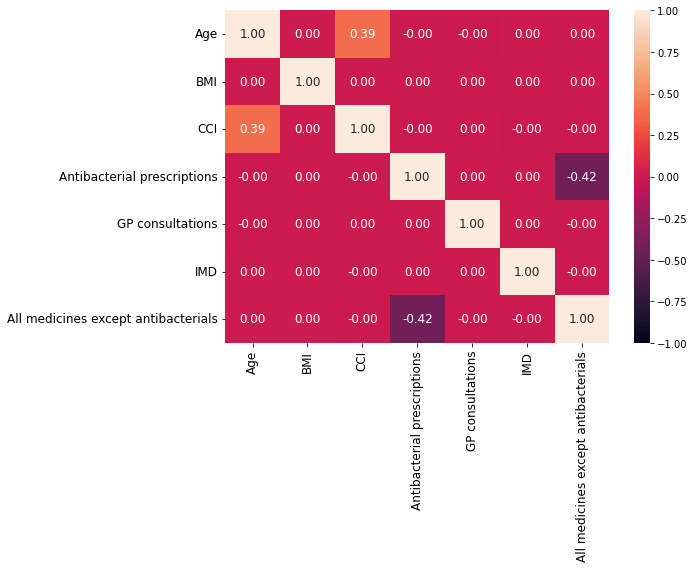

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
plt.show()

#### 1-3-2- Imputation of missing values
We impute variables with missing values that at most 50 pecent of their values are missing.

In [29]:
# prep before plot
data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
# data['bmi'][data['bmi'] <= 0] = 0

# remove cases with negative gp_count
data['gp_count'][data['gp_count'] < 0] = np.nan

# remove cases with negative antibacterial_brit
data['antibacterial_brit'][data['antibacterial_brit'] < 0] = np.nan

In [30]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data = data.replace({"sex": dict_sex})
data = data.replace({"smoking_status": dict_smoking})

In [31]:
# if ('bmi' in data.columns) and (data['bmi'].isnull().sum() > 0):
if ('bmi' in data.columns):
    # # iterative imputation with sklearn package
    imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=0)
    imputer.fit(data[['age', 'sex', 'CCI', 'bmi']])# 'CCI']])
    # data['bmi_imp'] = np.nan
    data['bmi_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi']]))[:,3]

    data['bmi'].isnull().sum()

In [32]:
# if ('imd' in data.columns) and (data['imd'].isnull().sum() > 0):
if ('imd' in data.columns):
    # # iterative imputation with sklearn package
    imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=0)
    imputer.fit(data[['age', 'sex', 'CCI', 'imd']])#'bmi_imp']])
    # data['imd_imp'] = np.nan
    data['imd_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'imd']]))[:,3]

In [33]:
# if ('smoking_status' in data.columns) and (data['smoking_status'].isnull().sum() > 0):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'smoking_status']])#'imd']]) # 'imd_imp'
#     # data['smoking_status_imp'] = np.nan
#     data['smoking_status_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'smoking_status']]))[:,4]

if ('smoking_status' in data.columns) and (data['smoking_status'].isnull().sum() > 0):
    data['smoking_status_imp'] = data['smoking_status'].replace(np.nan, 0)

# data['smoking_status_imp'].value_counts()

In [34]:
# if ('ethnicity' in data.columns) and (data['ethnicity'].isnull().sum() > 0):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity']])# 'smoking_status_imp']]) #'imd_imp'
#     # data['ethnicity_imp'] = np.nan
#     data['ethnicity_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity']]))[:,5] #'imd_imp'

if ('ethnicity' in data.columns) and (data['ethnicity'].isnull().sum() > 0):
    data['ethnicity_imp'] = data['ethnicity'].replace(np.nan, 0)

In [35]:
# # if ('gp_count' in data.columns) and (data['gp_count'].isnull().sum() > 0):
# if ('gp_count' in data.columns):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'gp_count']])# 'ethnicity_imp']]) # 'imd_imp'
#     # data['gp_count_imp'] = np.nan
#     data['gp_count_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'gp_count']]))[:,6] #'imd_imp'

# drop gp_count value missing
if ('gp_count' in data.columns) and (data['gp_count'].isnull().sum() >= 0):
    data['gp_count_imp'] = data['gp_count']
    data = data[data['gp_count_imp'].notna()]

In [36]:
# # if ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() > 0):
# if ('antibacterial_brit' in data.columns):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'ethnicity_imp', 'antibacterial_brit']])# 'gp_count']]) #'imd_imp'
#     # data['antibacterial_brit_imp'] = np.nan
#     data['antibacterial_brit_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'ethnicity_imp', 'antibacterial_brit']]))[:,7] # 'imd_imp'

# drop antibacterial_brit value missing
if ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() >= 0):
    data['antibacterial_brit_imp'] = data['antibacterial_brit']
    data = data[data['antibacterial_brit_imp'].notna()]

In [39]:
# data['antibacterial_brit_imp'].value_counts()
data['antibacterial_brit'].isnull().sum()

0

In [40]:
# # if ('region' in data.columns) and (data['region'].isnull().sum() > 0):
# if ('region' in data.columns):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity_imp', 'region']])
#     # data['region_imp'] = np.nan
#     data['region_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity_imp', 'region']]))[:,7] # 'imd_imp'

# drop region value missing
if ('region' in data.columns) and (data['region'].isnull().sum() >= 0):
    data['region_imp'] = data['region']
    data = data[data['region_imp'].notna()]

### 1-4- Translating states with dictionaries

In [41]:
# define dictionaries
dict_sex = {0: 'Female', 1: 'Male'}
# dict_BMI_cat= {'Underweight': 'Underweight', 'Healthy weight': 'Healthy weight', 'Overweight': 'Overweight', 'Obese': 'Obese', 
#                 np.nan: 'Unknown'}
# dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
# dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
dict_ethnicity_imp = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown'}
# dict_smoking_imp = {1:'Smoker', 2:'Ex-smoker', 3:'Never smoked'}
dict_smoking_imp = {1:'Smoker', 2:'Ex-smoker', 3:'Never smoked', 0: 'Unknown'}
# dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
# dict_smoking_status= {'Smoker': 'Smoker', 'Never smoked': 'Never smoked', 'Ex-smoker': 'Ex-smoker', 'Unknown': 'Unknown', 
#                        np.nan: 'Unknown'}
# dict_gp_count_cat= {'Few': 'Few', 'Some': 'Some', 'Many': 'Many', 'Too many': 'Too many', np.nan: 'Unknown'}
dict_flu = {0: 'No', 1: 'Yes'}

In [42]:
# reoplace values of dictionaries with existing ones
data = data.replace({"sex": dict_sex})
# data = data.replace({"BMI_cat": dict_BMI_cat})
# data = data.replace({"imd": dict_imd_imp})
data = data.replace({"ethnicity_imp": dict_ethnicity_imp})
data = data.replace({"smoking_status_imp": dict_smoking_imp})
# data = data.replace({"smoking_status": dict_smoking_status})
# data = data.replace({"gp_count_cat": dict_gp_count_cat})
data = data.replace({"flu_vaccine": dict_flu})

In [43]:
# categorising
data['BMI_cat'] = pd.cut(data['bmi_imp'], right=False, bins=[0,18.5,25,30,200], labels=['Underweight', 'Healthy weight', 'Overweight', 'Obese'])
data['gp_count_cat'] = pd.cut(data['gp_count_imp'], right=False, bins=[0,3,8,12,100], labels=['Few', 'Some', 'Many', 'Too many'])
data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,8,99], labels=['No', 'Low', 'Moderate', 'High', 'Very high'])
data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,18,60,200], labels=['0-17 years', '18-59 years', '>59 years'])

# if ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() >= 0):
# data['antibacterial_brit_cat'] = pd.cut(data['antibacterial_brit_imp'], right=False, bins=[0,1,5,20,50,1000000], labels=['None', 'Few', 'Some', 'Many', 'Too many'])
data['antibacterial_brit_cat'] = pd.cut(data['antibacterial_brit_imp'], right=False, bins=[0,5,20,1000000], labels=['Few', 'Some', 'Many'])

# if ('meds_nonabs' in data.columns) and (data['meds_nonabs'].isnull().sum() >= 0):
# data['meds_nonabs_cat'] = pd.cut(data['meds_nonabs'], right=False, bins=[0,1,10,50,200,4000000], labels=['None', 'Few', 'Some', 'Many', 'Too many'])
data['meds_nonabs_cat'] = pd.cut(data['meds_nonabs'], right=False, bins=[0,5,20,1000000], labels=['Few', 'Some', 'Many'])

In [46]:
# data['antibacterial_brit_imp'].value_counts()
data['antibacterial_brit_cat'].isnull().sum()

0

In [44]:
data.describe(include='all')

,deregistered_date,died_date,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,admitted_date,urti_date_1,urti_date_2,...,ethnicity_imp,gp_count_imp,antibacterial_brit_imp,region_imp,BMI_cat,gp_count_cat,CCI_cat,Age_cat,antibacterial_brit_cat,meds_nonabs_cat
count,9929,19888,149066,19871,19869,19879,19883,59623,19859,19879,...,198765,198765.000000,198765.000000,198765,198726,198765,198765,198765,198765,198765
unique,1210,695,40,40,40,13,13,1210,1210,1210,...,4,NaN,NaN,9,4,4,5,3,2,2
top,2020-07-05,2022-04-15,2020-07,2021-06,2020-06,2018-03,2018-12,2021-03-18,2021-02-17,2020-07-04,...,White,NaN,NaN,London,Obese,Few,Low,18-59 years,Few,Few
freq,19,177,3986,553,556,1750,1717,72,28,31,...,119153,NaN,NaN,40051,155427,97861,49669,108973,196479,197602
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.342047,1.250784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.539208,1.451257,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# save data
# data.to_csv("../output/hospitalisation_prediction_urti/data_imputed.csv")

# input_file_path = makeFilePath("output/hospitalisation_prediction_urti/", "data_imputed.csv")
# data = pd.read_csv(input_file_path)

# data = pd.read_csv('output/hospitalisation_prediction_urti/data_imputed.csv')
# data.shape#head()

### 1-5- Polynimial featuring

## 2- Plots
### 2-1- Continuous factors

In [1]:
# fig, axes = plt.subplots(3,2, 
#                         figsize=(15, 15)
#                         )
# create_histplot('BMI', data['bmi'], axes[0,0])
# create_histplot('Age', data['age'], axes[0,1])
# create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
# create_histplot('Practice', data['practice'], axes[1,1])
# create_histplot('CCI', data['CCI'], axes[2,0])
# fig.delaxes(ax=axes[2,1])

# fig.suptitle('Risk Factors', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont.jpg')
# plt.show()

In [62]:
# p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
#                              ], 
#                 hue = 'admitted', # 'antibacterial_brit', 
# #                kind='reg', 
#                 #markers=["o", "s"], 
#                 diag_kind="kde",#"hist"
# #                plot_kws={#'line_kws':{'color':'red'}, 
#                 plot_kws={'alpha':0.3},
#                 height = 3)

# p.axes[0,2].set_xlim((0,20))
# p.axes[0,2].set_ylim((0,100))

# p.axes[1,1].set_xlim((0,75))
# p.axes[1,1].set_ylim((0,75))

# p.axes[2,0].set_xlim((0,100))
# p.axes[2,0].set_ylim((0,20))

# p.axes[0,3].set_xlim((0,20))
# p.axes[3,0].set_ylim((0,20))

# plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont_pairplot.jpg')
# plt.show()

### 2-2- Categorical factors

In [63]:
# fig, axes = plt.subplots(7,2,
#                         figsize=(15, 10)
#                         )
# create_lineplot(data, 'sex', 'Sex', 'Sex', axes[0,0])
# create_lineplot(data, 'age_cat', 'Age category', 'Age category', axes[0,1])
# create_lineplot(data, 'imd_imp', 'IMD', 'IMD', axes[1,0])
# create_lineplot(data, 'ethnicity_imp', 'Ethnicity', 'Ethnicity', axes[1,1])
# create_lineplot(data, 'smoking_status_imp', 'Smoking status', 'Smoking status', axes[2,0])
# create_lineplot(data, 'BMI_cat', 'BMI', 'BMI', axes[2,1])
# create_lineplot(data, 'CCI_cat', 'CCI', 'CCI', axes[1,0])
# create_lineplot(data, 'gp_count_cat', 'GP consultation', 'GP consultation', axes[3,1])
# create_lineplot(data, 'region', 'Region', 'Region', axes[4,0])
# create_lineplot(data, 'flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
# create_lineplot(data, 'antibacterial_brit_imp', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data, 'msoa', 'msoa', 'MSOA', axes[5,1])
# create_lineplot(data, 'meds_nonabs', 'Medicines excpet antibacterials', 'Medicines excpet antibacterials', axes[6,0])
# fig.delaxes(ax=axes[6,1])

# fig.suptitle('Risk Factors', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat.jpg')
# plt.show()

## 3- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 3-1- URTI

#### URTI-1

In [47]:
data_urti_1 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_1', 'gp_cons_urti_ab_1',
                    'urti_date_1', 'incdt_urti_date_1', 'admitted_urti_date_1', 'sgss_gp_cov_urti_date_1']]

data_urti_1 = data_urti_1[data_urti_1['urti_date_1'].notnull()]

data_urti_1.shape

(19859, 31)

In [48]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_1
data_urti_1 = data_urti_1[data_urti_1['sgss_gp_cov_urti_date_1'] == 0]
data_urti_1.shape

(17875, 31)

In [49]:
data_urti_1.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat',
       'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 'region_imp',
       'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp',
       'antibacterial_brit_imp', 'antibacterial_brit_cat', 'hx_hosp',
       'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat', 'died_date',
       'deregistered_date', 'gp_cons_urti_1', 'gp_cons_urti_ab_1',
       'urti_date_1', 'incdt_urti_date_1', 'admitted_urti_date_1',
       'sgss_gp_cov_urti_date_1'],
      dtype='object')

In [50]:
# drop rows with no gp_cons_urti_1 records
data_urti_1 = data_urti_1.dropna(subset=['gp_cons_urti_1'])
data_urti_1.shape

(1885, 31)

#### URTI-2

In [51]:
data_urti_2 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_2', 'gp_cons_urti_ab_2',
                    'urti_date_2', 'incdt_urti_date_2', 'admitted_urti_date_2', 'sgss_gp_cov_urti_date_2']]

data_urti_2 = data_urti_2[data_urti_2['urti_date_2'].notnull()]

data_urti_2.shape

(19879, 31)

In [52]:
data_urti_1.urti_date_1.value_counts()

2021-08-22    8
2020-10-18    6
2020-06-14    6
2019-09-24    6
2021-11-22    6
             ..
2021-11-07    1
2020-07-10    1
2022-02-07    1
2022-04-03    1
2019-08-19    1
Name: urti_date_1, Length: 960, dtype: int64

In [53]:
data_urti_2.urti_date_2.value_counts()

2020-07-04    31
2019-07-22    31
2019-10-02    29
2020-05-08    29
2019-12-22    29
              ..
2021-01-15     6
2019-08-08     5
2021-01-14     4
2021-09-11     4
2019-12-24     4
Name: urti_date_2, Length: 1210, dtype: int64

In [54]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_2
data_urti_2 = data_urti_2[data_urti_2['sgss_gp_cov_urti_date_2'] == 0]
data_urti_2.shape

(17892, 31)

In [55]:
data_urti_2.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat',
       'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 'region_imp',
       'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp',
       'antibacterial_brit_imp', 'antibacterial_brit_cat', 'hx_hosp',
       'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat', 'died_date',
       'deregistered_date', 'gp_cons_urti_2', 'gp_cons_urti_ab_2',
       'urti_date_2', 'incdt_urti_date_2', 'admitted_urti_date_2',
       'sgss_gp_cov_urti_date_2'],
      dtype='object')

In [56]:
# drop rows with no gp_cons_urti_2 records
data_urti_2 = data_urti_2.dropna(subset=['gp_cons_urti_2'])
data_urti_2.shape

(1780, 31)

#### URTI_3

In [57]:
data_urti_3 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_3', 'gp_cons_urti_ab_3',
                    'urti_date_3', 'incdt_urti_date_3', 'admitted_urti_date_3', 'sgss_gp_cov_urti_date_3']]

data_urti_3 = data_urti_3[data_urti_3['urti_date_3'].notnull()]

data_urti_3.shape

(19892, 31)

In [58]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_3
data_urti_3 = data_urti_3[data_urti_3['sgss_gp_cov_urti_date_3'] == 0]
data_urti_3.shape

(17893, 31)

In [59]:
data_urti_3.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat',
       'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 'region_imp',
       'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp',
       'antibacterial_brit_imp', 'antibacterial_brit_cat', 'hx_hosp',
       'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat', 'died_date',
       'deregistered_date', 'gp_cons_urti_3', 'gp_cons_urti_ab_3',
       'urti_date_3', 'incdt_urti_date_3', 'admitted_urti_date_3',
       'sgss_gp_cov_urti_date_3'],
      dtype='object')

In [60]:
# drop rows with no gp_cons_urti_3 records
data_urti_3 = data_urti_3.dropna(subset=['gp_cons_urti_3'])
data_urti_3.shape

(1745, 31)

#### URTI_4

In [61]:
data_urti_4 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_4', 'gp_cons_urti_ab_4',
                    'urti_date_4', 'incdt_urti_date_4', 'admitted_urti_date_4', 'sgss_gp_cov_urti_date_4']]

data_urti_4 = data_urti_4[data_urti_4['urti_date_4'].notnull()]

data_urti_4.shape

(19873, 31)

In [62]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_4
data_urti_4 = data_urti_4[data_urti_4['sgss_gp_cov_urti_date_4'] == 0]
data_urti_4.shape

(17875, 31)

In [63]:
data_urti_4.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat',
       'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 'region_imp',
       'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp',
       'antibacterial_brit_imp', 'antibacterial_brit_cat', 'hx_hosp',
       'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat', 'died_date',
       'deregistered_date', 'gp_cons_urti_4', 'gp_cons_urti_ab_4',
       'urti_date_4', 'incdt_urti_date_4', 'admitted_urti_date_4',
       'sgss_gp_cov_urti_date_4'],
      dtype='object')

In [64]:
data_urti_4.shape

(17875, 31)

In [65]:
# data_urti_4.gp_cons_urti_4.value_counts()#isnull().sum()
data_urti_4.gp_cons_urti_4.isnull().sum()

16152

In [66]:
# drop rows with no gp_cons_urti_4 records
data_urti_4 = data_urti_4.dropna(subset=['gp_cons_urti_4'])
data_urti_4.shape

(1723, 31)

#### Combining URTI_1, URTI_2, URTI_3, and URTI_4

In [67]:
data_urti_1.rename(columns={'urti_date_1': 'urti_date',
                           'gp_cons_urti_1': 'gp_cons_urti', 'gp_cons_urti_ab_1': 'gp_cons_urti_ab',
                           'incdt_urti_date_1': 'incdt_urti_date', #'prevl_urti_date_1': 'prevl_urti_date',
                           'admitted_urti_date_1': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_1': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_2.rename(columns={'urti_date_2': 'urti_date',
                           'gp_cons_urti_2': 'gp_cons_urti', 'gp_cons_urti_ab_2': 'gp_cons_urti_ab',
                           'incdt_urti_date_2': 'incdt_urti_date', #'prevl_urti_date_2': 'prevl_urti_date', 
                           'admitted_urti_date_2': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_2': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_3.rename(columns={'urti_date_3': 'urti_date',
                           'gp_cons_urti_3': 'gp_cons_urti', 'gp_cons_urti_ab_3': 'gp_cons_urti_ab',
                           'incdt_urti_date_3': 'incdt_urti_date', #'prevl_urti_date_3': 'prevl_urti_date', 
                           'admitted_urti_date_3': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_3': 'sgss_gp_cov_urti_date'},
                 inplace=True)
data_urti_4.rename(columns={'urti_date_4': 'urti_date', 
                           'gp_cons_urti_4': 'gp_cons_urti', 'gp_cons_urti_ab_4': 'gp_cons_urti_ab',
                           'incdt_urti_date_4': 'incdt_urti_date', #'prevl_urti_date_4': 'prevl_urti_date',
                           'admitted_urti_date_4': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_4': 'sgss_gp_cov_urti_date'}, 
                 inplace=True)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4])
data_urti.reset_index(inplace=True, drop=True)
data_urti.shape

(7133, 31)

In [68]:
data_urti_4.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat',
       'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 'region_imp',
       'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp',
       'antibacterial_brit_imp', 'antibacterial_brit_cat', 'hx_hosp',
       'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat', 'died_date',
       'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab', 'urti_date',
       'incdt_urti_date', 'admitted_urti_date', 'sgss_gp_cov_urti_date'],
      dtype='object')

In [69]:
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['gp_cons_urti'] = data_urti['gp_cons_urti'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')
data_urti.shape

(7133, 31)

In [70]:
#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['gp_cons_urti']
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')

In [71]:
#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = ['Spring', 'Summer', 'Autumn']
data_urti['season'] = np.select(conditions, choices, default='Winter')

data_urti['season'].value_counts()

Spring    2018
Winter    1860
Summer    1640
Autumn    1615
Name: season, dtype: int64

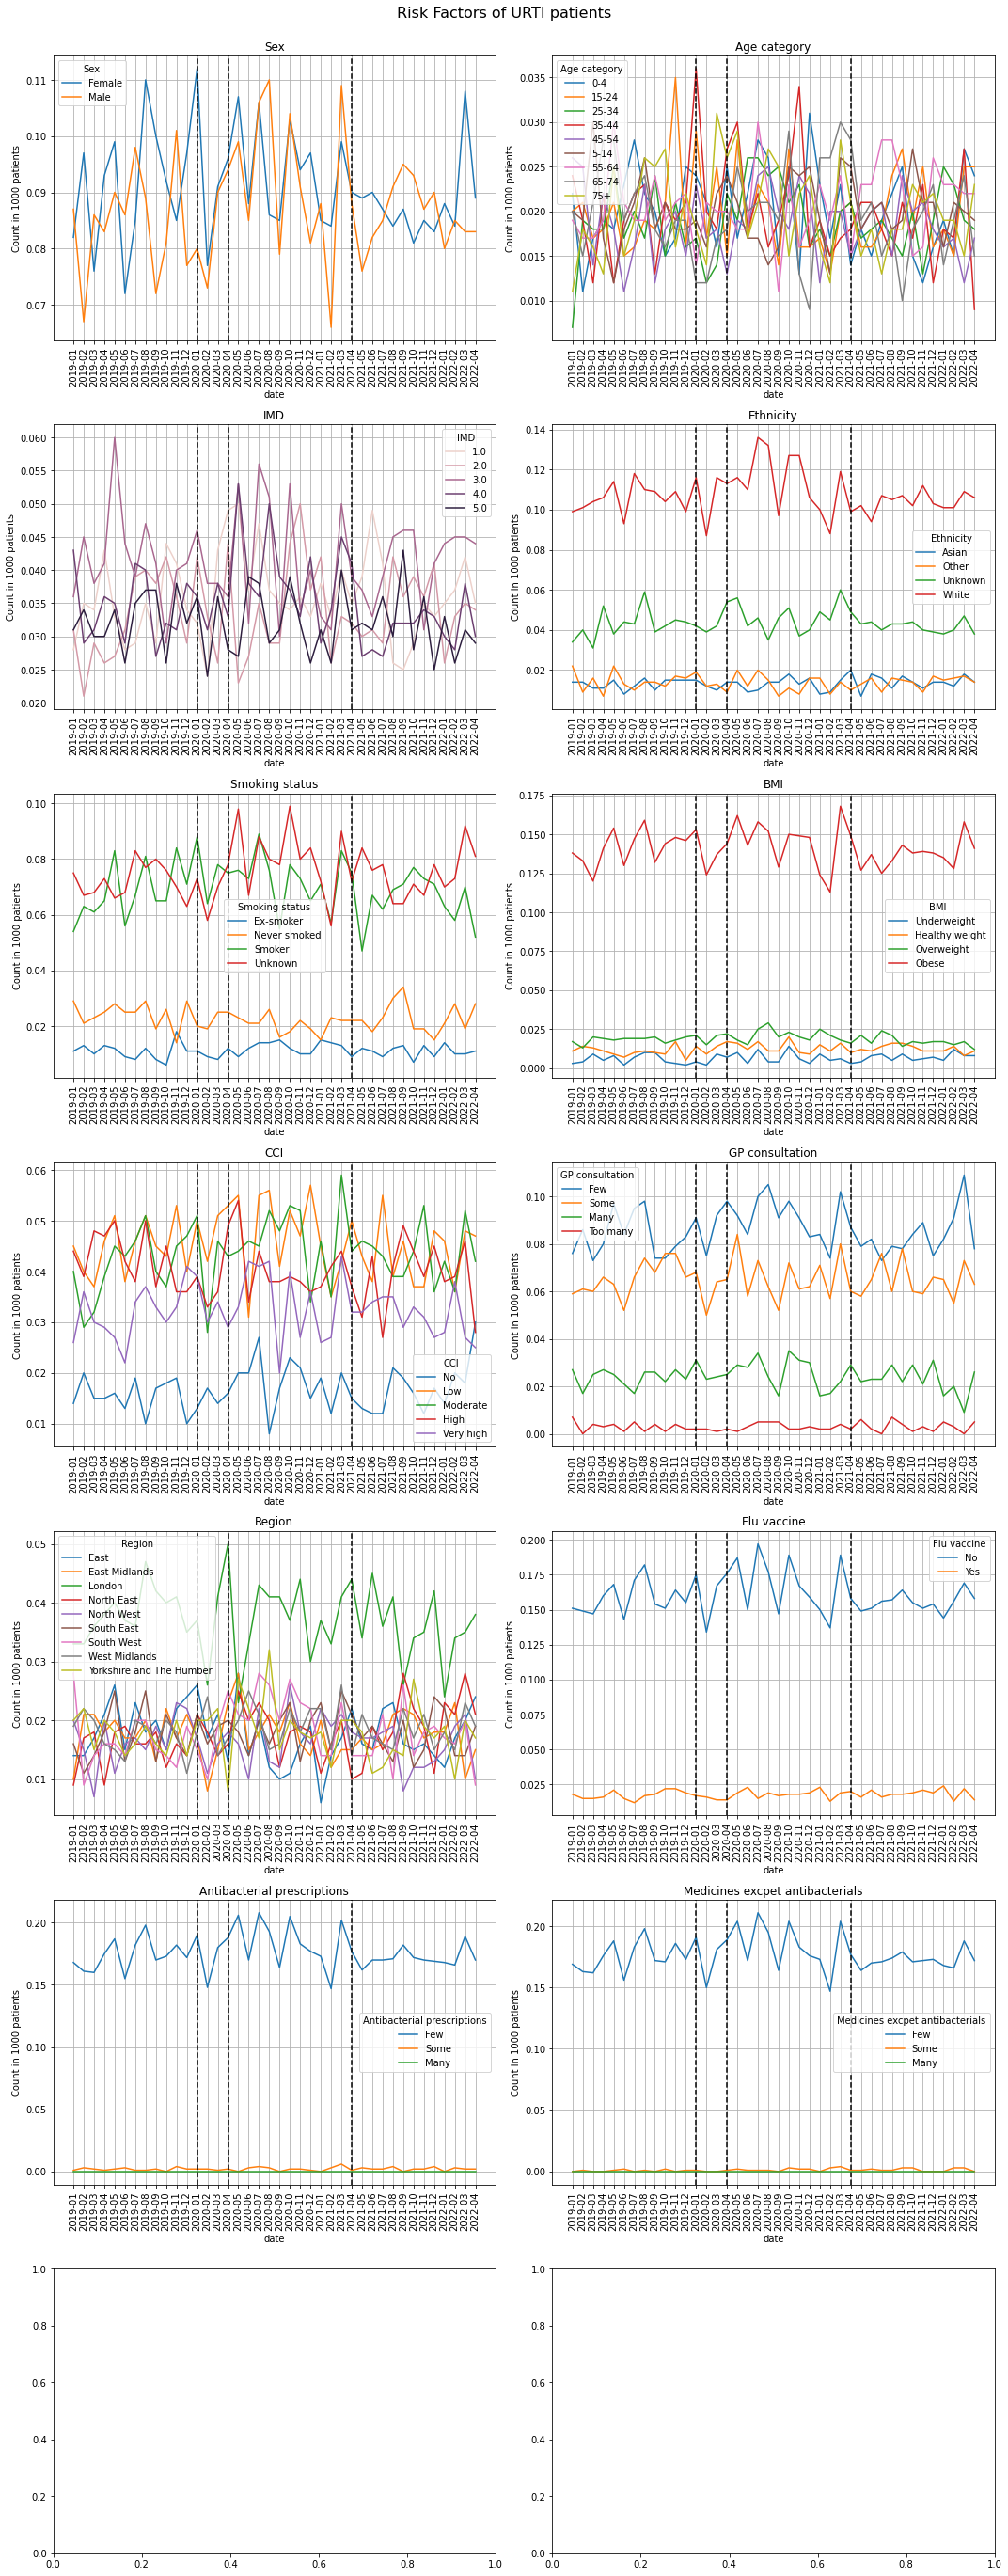

In [72]:
fig, axes = plt.subplots(7,2,
                        figsize=(15, 40)
                        )
create_lineplot(data_urti, 'sex', 'Sex', 'Sex', axes[0,0])
create_lineplot(data_urti, 'age_cat', 'Age category', 'Age category', axes[0,1])
create_lineplot(data_urti, 'imd_imp', 'IMD', 'IMD', axes[1,0])
create_lineplot(data_urti, 'ethnicity_imp', 'Ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_urti, 'smoking_status_imp', 'Smoking status', 'Smoking status', axes[2,0])
create_lineplot(data_urti, 'BMI_cat', 'BMI', 'BMI', axes[2,1])
create_lineplot(data_urti, 'CCI_cat', 'CCI', 'CCI', axes[3,0])
create_lineplot(data_urti, 'gp_count_cat', 'GP consultation', 'GP consultation', axes[3,1])
create_lineplot(data_urti, 'region_imp', 'Region', 'Region', axes[4,0])
create_lineplot(data_urti, 'flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
create_lineplot(data_urti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data_urti, 'msoa', 'msoa', 'MSOA', axes[5,1])
create_lineplot(data_urti, 'meds_nonabs_cat', 'Medicines excpet antibacterials', 'Medicines excpet antibacterials', axes[5,1])
# fig.delaxes(ax=axes[6,1])

fig.suptitle('Risk Factors of URTI patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat_urti.jpg')
plt.show()

#### Adding event and duration columns

In [73]:
#scenario 1
#not hosped (nothing happened)
#data_urti = data_urti[data_urti['admitted_urti_date'].notnull()]
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    4953
Name: event_urti_admitted, dtype: int64

In [74]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['gp_cons_urti']).dt.days
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    4953
1.0      51
Name: event_urti_admitted, dtype: int64

In [75]:
#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]
data_urti['delta_urti_admitted'].value_counts()

243.0     7
100.0     6
159.0     6
337.0     5
40.0      5
         ..
621.0     1
637.0     1
442.0     1
1034.0    1
505.0     1
Name: delta_urti_admitted, Length: 642, dtype: int64

In [76]:
# data_urti['event_urti_admitted'].value_counts()
data_urti['event_urti_admitted'].isnull().sum()

1065

In [77]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_died'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    4961
1.0      50
Name: event_urti_admitted, dtype: int64

In [78]:
#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_deregistered'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    4961
1.0      50
Name: event_urti_admitted, dtype: int64

In [79]:
#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_urti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

5965

In [80]:
data_urti['delta_admitted_died_deregistered'].value_counts()

157.0    2
34.0     2
59.0     2
130.0    1
234.0    1
        ..
205.0    1
361.0    1
113.0    1
587.0    1
796.0    1
Name: delta_admitted_died_deregistered, Length: 101, dtype: int64

In [81]:
#censor patients that had a history of hospital admission
# data_urti.loc[data_urti['hx_hosp'] == 1, 'event_urti_admitted'] = 0

In [82]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)
data_urti['event_urti_admitted'].value_counts()

0.0    6019
1.0      50
Name: event_urti_admitted, dtype: int64

In [83]:
#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30
data_urti['duration_urti_admitted'].value_counts()

30.0    6018
1.0        4
26.0       4
13.0       4
6.0        4
14.0       3
9.0        3
27.0       3
17.0       3
21.0       3
18.0       3
8.0        3
22.0       2
20.0       2
7.0        2
15.0       1
25.0       1
4.0        1
16.0       1
2.0        1
19.0       1
29.0       1
12.0       1
Name: duration_urti_admitted, dtype: int64

In [84]:
# give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    6018
1.0      51
Name: event_urti_admitted, dtype: int64

In [85]:
#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

In [86]:
data_urti[data_urti['duration_urti_admitted']==0][['delta_urti_admitted', 'urti_date', 'gp_cons_urti', 'admitted_urti_date', 'delta_urti_admitted', 'delta_admitted_died_deregistered', 'event_urti_admitted', 'duration_urti_admitted']]

,delta_urti_admitted,urti_date,gp_cons_urti,admitted_urti_date,delta_urti_admitted,delta_admitted_died_deregistered,event_urti_admitted,duration_urti_admitted


In [87]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

In [88]:
# data_urti['duration_urti_admitted'].value_counts()

In [89]:
# data_urti.loc[151:200, ['event_urti_admitted', 'duration_urti_admitted']]
# data_urti.loc[201:250, ['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])
data_urti[['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])

,event_urti_admitted,duration_urti_admitted
1674,1.0,1.0
5843,1.0,1.0
4609,1.0,1.0
7042,1.0,1.0
5702,1.0,2.0
...,...,...
2391,0.0,30.0
2390,0.0,30.0
2389,0.0,30.0
2399,0.0,30.0


#### Separate data of URTI
We separate data of urti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [90]:
# no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]

print(f'shape of data_urti_no_abs_incdt: {data_urti_no_abs_incdt.shape}')
print(f'shape of data_urti_abs_incdt: {data_urti_abs_incdt.shape}')
print(f'shape of data_urti_no_abs_prevl: {data_urti_no_abs_prevl.shape}')
print(f'shape of data_urti_abs_prevl: {data_urti_abs_prevl.shape}')

shape of data_urti_no_abs_incdt: (4895, 40)
shape of data_urti_abs_incdt: (560, 40)
shape of data_urti_no_abs_prevl: (554, 40)
shape of data_urti_abs_prevl: (60, 40)


## 4- Cox modelling for hospital admissions related to infections 
### 4-1- URTI
#### 4-1-1- Incident hospital admission related to URTI with no antibiotics

In [91]:
data_urti_no_abs_incdt.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat',
       'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 'region_imp',
       'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp',
       'antibacterial_brit_imp', 'antibacterial_brit_cat', 'hx_hosp',
       'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat', 'died_date',
       'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab', 'urti_date',
       'incdt_urti_date', 'admitted_urti_date', 'sgss_gp_cov_urti_date',
       'date', 'season', 'date_month', 'event_urti_admitted',
       'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [92]:
data_urti_no_abs_incdt.shape

(4895, 40)

In [93]:
#keep relevant variables
# data_urti_no_abs_incdt = data_urti_no_abs_incdt[['age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count_imp', 'flu_vaccine',
#                                                'region_imp', 'antibacterial_brit_imp', 'imd_imp', 'ethnicity_imp', 'CCI_cat', 'CCI',
#                                                'event_urti_admitted', 'duration_urti_admitted']]

data_urti_no_abs_incdt = data_urti_no_abs_incdt[['age_cat', 'CCI_cat', 'age', 'bmi_imp', 'gp_count_imp', 
                                                 'flu_vaccine', 'sex', 'region_imp', 'season', 
                                                 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
                                                 'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
                                                 'event_urti_admitted', 'duration_urti_admitted']]

In [94]:
# printing number of missing values in each variable 
data_urti_no_abs_incdt.isnull().sum()

age_cat                   0
CCI_cat                   0
age                       0
bmi_imp                   0
gp_count_imp              0
flu_vaccine               0
sex                       0
region_imp                0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
antibacterial_brit_cat    0
smoking_status_imp        0
meds_nonabs               0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [95]:
# #drop ros with missing values
# data_urti_no_abs_incdt = data_urti_no_abs_incdt.dropna(axis='rows')
# # data_urti = data_urti.drop(columns=['smoking_status'])
# data_urti_no_abs_incdt.isnull().sum()

In [96]:
data_urti_no_abs_incdt.columns

Index(['age_cat', 'CCI_cat', 'age', 'bmi_imp', 'gp_count_imp', 'flu_vaccine',
       'sex', 'region_imp', 'season', 'imd_imp', 'antibacterial_brit_imp',
       'ethnicity_imp', 'antibacterial_brit_cat', 'smoking_status_imp',
       'meds_nonabs', 'meds_nonabs_cat', 'event_urti_admitted',
       'duration_urti_admitted'],
      dtype='object')

In [97]:
fold_thre = len(data_urti_no_abs_incdt)-round(len(data_urti_no_abs_incdt)/4)
data_urti_no_abs_incdt_train = data_urti_no_abs_incdt.iloc[:fold_thre]
data_urti_no_abs_incdt_test = data_urti_no_abs_incdt.iloc[fold_thre:]

print(f'shape of data_urti_no_abs_incdt for training: {data_urti_no_abs_incdt_train.shape}')
print(f'shape of data_urti_no_abs_incdt for testing: {data_urti_no_abs_incdt_test.shape}')

shape of data_urti_no_abs_incdt for training: (3671, 18)
shape of data_urti_no_abs_incdt for testing: (1224, 18)


In [109]:
cph_urti_no_abs_incdt = CoxPHFitter()
cph_urti_no_abs_incdt.fit(data_urti_no_abs_incdt_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + bmi_imp + gp_count_imp + flu_vaccine + region_imp + imd_imp"# + antibacterial_brit_imp + ethnicity_imp + smoking_status_imp + season + meds_nonabs_cat"
        #, show_progress=True
        #, step_size=0.01
        )
cph_urti_no_abs_incdt.print_summary()
# cph_urti_no_abs_incdt_summary = cph_urti_no_abs_incdt.print_summary(style="html")
# cph_urti_no_abs_incdt.print_summary(columns=["coef", "se(coef)", "p"])

<lifelines.CoxPHFitter: fitted with 3671 total observations, 3641 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 3671
number of events observed = 30
   partial log-likelihood = -233.78
         time fit was run = 2022-04-26 08:16:54 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
CCI_cat[T.Low]                           0.19       1.21       0.66            -1.10             1.47                 0.33                 4.37
CCI_cat[T.Moderate]                     -0.29       0.75       0.71            -1.68             1.10                 0.19                 3.02
CCI_cat[T.High]                         -0.38       0.69       0.73            -1.81             1.06                 0.16                 2.89
CCI_cat[T.Very high]                    -0.28       0.75       0.73            -1.72             1.16                 0.18                 3.17
age_cat[T.15-24]                         0.42       1.52       0.73            -1.02             1.86                 0.36                 6.43
age_cat[T.25-34]                        -0.31       0.73       0.92            -2.11             1.48                 0.12                 4.41
age_cat[T.35-44]                        -0.32       0.73       0.92            -2.12             1.47                 0.12                 4.36
age_cat[T.45-54]                        -0.31       0.74       0.92            -2.10             1.49                 0.12                 4.44
age_cat[T.5-14]                          0.82       2.27       0.71            -0.57             2.21                 0.56                 9.12
age_cat[T.55-64]                        -0.04       0.96       0.82            -1.64             1.57                 0.19                 4.80
age_cat[T.65-74]                        -0.44       0.65       0.92            -2.24             1.36                 0.11                 3.90
age_cat[T.75+]                           0.59       1.81       0.74            -0.85             2.04                 0.43                 7.66
antibacterial_brit_imp                   0.11       1.12       0.12            -0.13             0.35                 0.88                 1.42
bmi_imp                                 -0.05       0.95       0.02            -0.09            -0.01                 0.91                 0.99
flu_vaccine[T.Yes]                       0.60       1.83       0.49            -0.36             1.57                 0.69                 4.83
gp_count_imp                            -0.02       0.98       0.05            -0.13             0.09                 0.88                 1.09
region_imp[T.East Midlands]             -0.41       0.66       0.91            -2.20             1.38                 0.11                 3.97
region_imp[T.London]                    -0.30       0.74       0.73            -1.73             1.14                 0.18                 3.12
region_imp[T.North East]                 0.55       1.73       0.71            -0.85             1.95                 0.43                 7.02
region_imp[T.North West]                 0.01       1.01       0.82            -1.60             1.62                 0.20                 5.06
region_imp[T.South East]                -0.50       0.61       0.92            -2.29             1.30                 0.10                 3.66
region_imp[T.South West]                -1.13       0.32       1.16            -3.40             1.14                 0.03                 3.12
region_imp[T.West Midlands]              0.23       1.25       0.77            -1.28             1.73                 0.28                 5.67
region_im

In [125]:
output = GetPrintSummary(cph_urti_no_abs_incdt)

with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

11938


In [126]:
a = cph_urti_no_abs_incdt.baseline_hazard_
# cph_urti_no_abs_incdt.baseline_survival_
# cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt, data_urti_no_abs_incdt['duration_urti_admitted']<=30)
# cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_no_abs_incdt.txt', a, delimiter=',')

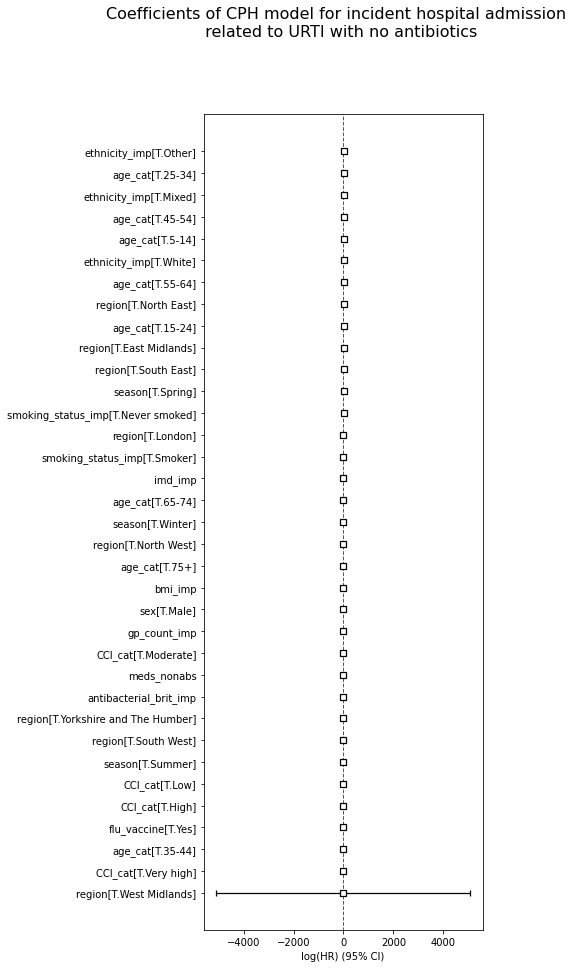

In [128]:
fig, ax = plt.subplots(figsize=(5, 10)
                        )
cph_urti_no_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [130]:
# concordance index of cph model with testing data
concord_index_urti_no_abs_incdt_test = concordance_index(data_urti_no_abs_incdt_test['event_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['duration_urti_admitted'])
print(f'Concordance index for urti_no_abs_incdt with testing data: {concord_index_urti_no_abs_incdt_test}')
# print(concordance_index(data_urti_no_abs_incdt_test['event_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['duration_urti_admitted']))

Concordance index for urti_no_abs_incdt with testing data: 0.5353917662682602


In [131]:
a = [concord_index_urti_no_abs_incdt_test]
np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_no_abs_incdt_test.txt', a, delimiter=',')

ICI =  0.008143954023107509
E50 =  0.005154752288704267


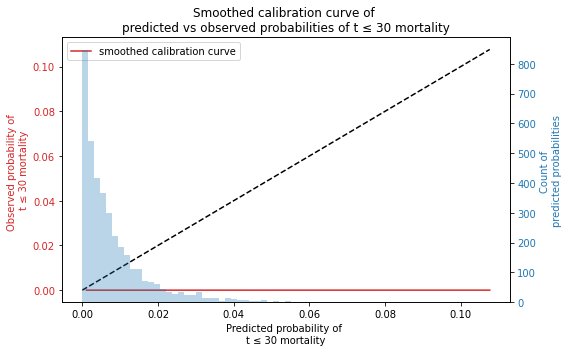

In [132]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, t0=30)
# plt.suptitle('Calibration of CPH model for incident hospital admission related to urti with no antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

# t0 (float) – the time to evaluate the probability of event occurring prior at.
# ICI – mean absolute difference between predicted and observed
# E50 – median absolute difference between predicted and observed

ICI =  0.007928486870639507
E50 =  0.004925206280336436


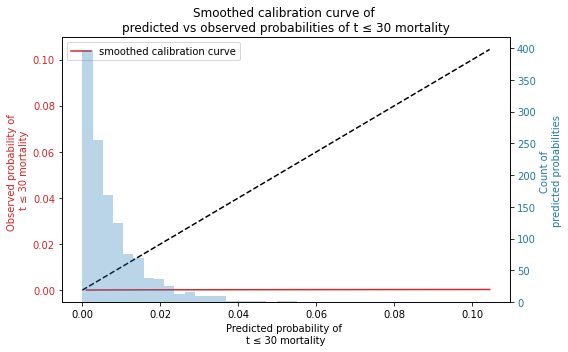

In [133]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_test, t0=30)
# plt.suptitle('Calibration of CPH model for incident hospital admission related to URTI with no antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [174]:
# print(cph_urti_no_abs_incdt.score(data_urti_no_abs_incdt_1_test))
# print(cph_urti_no_abs_incdt.concordance_index_)
# print(cph_urti_no_abs_incdt.AIC_partial_)
# print(cph_urti_no_abs_incdt.concordance_index_)

#### 4-1-2- Incident hospital admission related to URTI with antibiotics

In [110]:
data_urti_abs_incdt.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat',
       'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 'region_imp',
       'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp',
       'antibacterial_brit_imp', 'antibacterial_brit_cat', 'hx_hosp',
       'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat', 'died_date',
       'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab', 'urti_date',
       'incdt_urti_date', 'admitted_urti_date', 'sgss_gp_cov_urti_date',
       'date', 'season', 'date_month', 'event_urti_admitted',
       'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [111]:
data_urti_abs_incdt.shape

(560, 40)

In [112]:
#keep relevant variables
data_urti_abs_incdt = data_urti_abs_incdt[['age_cat', 'CCI_cat', 'age', 'bmi_imp', 'gp_count_imp', 
                                                 'flu_vaccine', 'sex', 'region_imp', 'season', 
                                                 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
                                                 'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
                                                 'event_urti_admitted', 'duration_urti_admitted']]

In [113]:
# printing number of missing values in each variable 
data_urti_abs_incdt.isnull().sum()

age_cat                   0
CCI_cat                   0
age                       0
bmi_imp                   0
gp_count_imp              0
flu_vaccine               0
sex                       0
region_imp                0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
antibacterial_brit_cat    0
smoking_status_imp        0
meds_nonabs               0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [91]:
# #drop ros with missing values
# data_urti_abs_incdt = data_urti_abs_incdt.dropna(axis='rows')
# #data_urti_abs_incdt = data_urti_abs_incdt.drop(columns=['smoking_status'])
# data_urti_abs_incdt.isnull().sum()

In [114]:
fold_thre = len(data_urti_abs_incdt)-round(len(data_urti_abs_incdt)/4)
data_urti_abs_incdt_train = data_urti_abs_incdt.iloc[:fold_thre]
data_urti_abs_incdt_test = data_urti_abs_incdt.iloc[fold_thre:]

print(f'shape of data_urti_abs_incdt for training: {data_urti_abs_incdt_train.shape}')
print(f'shape of data_urti_abs_incdt for testing: {data_urti_abs_incdt_test.shape}')

shape of data_urti_abs_incdt for training: (420, 18)
shape of data_urti_abs_incdt for testing: (140, 18)


In [115]:
cph_urti_abs_incdt = CoxPHFitter().fit(data_urti_abs_incdt_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat"# + sex + CCI_cat + bmi_imp + gp_count_imp + flu_vaccine + region_imp + imd_imp"
        )
cph_urti_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 420 total observations, 416 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 420
number of events observed = 4
   partial log-likelihood = -20.82
         time fit was run = 2022-04-26 09:29:10 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
age_cat[T.15-24] -17.12       0.00    5428.04        -10655.89         10621.65                 0.00                  inf
age_cat[T.25-34] -17.12       0.00    5259.25        -10325.07         10290.83                 0.00                  inf
age_cat[T.35-44] -17.12       0.00    5428.04        -10655.89         10621.65                 0.00                  inf
age_cat[T.45-54]   0.12       1.13       1.41            -2.65             2.89                 0.07                18.08
age_cat[T.5-14]  -17.12       0.00    5259.25        -10325.07         10290.83                 0.00                  inf
age_cat[T.55-64]   0.14       1.15       1.41            -2.63             2.91                 0.07                18.39
age_cat[T.65-74]   0.09       1.09       1.41            -2.68             2.86                 0.07                17.48
age_cat[T.75+]   -17.12       0.00    5428.04        -10655.89         10621.65                 0.00                  inf

                   cmp to     z    p   -log2(p)
covariate                                      
age_cat[T.15-24]     0.00 -0.00 1.00       0.00
age_cat[T.25-34]     0.00 -0.00 1.00       0.00
age_cat[T.35-44]     0.00 -0.00 1.00       0.00
age_cat[T.45-54]     0.00  0.09 0.93       0.10
age_cat[T.5-14]      0.00 -0.00 1.00       0.00
age_cat[T.55-64]     0.00  0.10 0.92       0.12
age_cat[T.65-74]     0.00  0.06 0.95       0.07
age_cat[T.75+]       0.00 -0.00 1.00       0.00
---
Concordance = 0.79
Partial AIC = 57.64
log-likelihood ratio test = 6.65 on 8 df
-log2(p) of ll-ratio test = 0.80

In [116]:
output = GetPrintSummary(cph_urti_abs_incdt)

with open('../output/hospitalisation_prediction_urti/cph_urti_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

4535


In [117]:
a = cph_urti_abs_incdt.baseline_hazard_
# cph_urti_abs_incdt.baseline_survival_
# cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt, data_urti_abs_incdt['duration_urti_admitted']<=30)
# cph_urti_abs_incdt.predict_survival_function(data_urti_abs_incdt)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_abs_incdt.txt', a, delimiter=',')

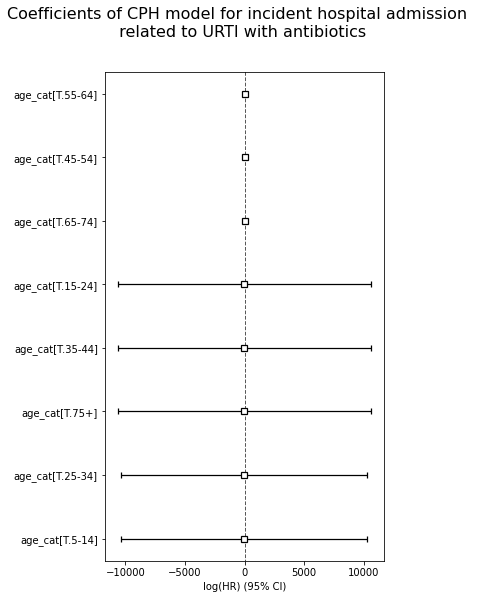

In [118]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_urti_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [119]:
# concordance index of cph model with testing data
concord_index_urti_abs_incdt_test = concordance_index(data_urti_abs_incdt_test['event_urti_admitted'], -cph_urti_abs_incdt.predict_partial_hazard(data_urti_abs_incdt_test), data_urti_abs_incdt_test['duration_urti_admitted'])
print(f'Concordance index for urti_abs_incdt with testing data: {concord_index_urti_abs_incdt_test}')

Concordance index for urti_abs_incdt with testing data: 0.7302158273381295


In [120]:
a = [concord_index_urti_abs_incdt_test]
np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_abs_incdt_test.txt', a, delimiter=',')

ICI =  0.009497896733425885
E50 =  7.332300322460128e-10


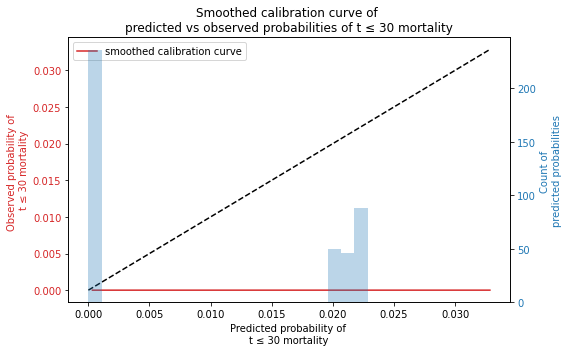

In [121]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, t0=30)
# plt.suptitle('Calibration of CPH model for incident hospital admission related to URTI with antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

In [123]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_test, t0=30)
# plt.suptitle('Calibration of CPH model for incident hospital admission related to urti with antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

#### 4-1-3- Prevalent hospital admission related to URTI with no antibiotics

In [109]:
# data_urti_no_abs_prevl.columns

In [111]:
# data_urti_no_abs_prevl.shape

In [112]:
# #keep relevant variables
# data_urti_no_abs_prevl = data_urti_no_abs_prevl[['age', 'bmi_imp', 'gp_count_imp', 'flu_vaccine', 'sex', 'region', #'season', 
#                                                 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'smoking_status_imp',
#                                                 'meds_nonabs',
#                                                 'event_urti_admitted', 'duration_urti_admitted']]

In [113]:
# # printing number of missing values in each variable 
# data_urti_no_abs_prevl.isnull().sum()

In [98]:
# #drop rows with missing values
# data_urti_no_abs_prevl = data_urti_no_abs_prevl.dropna(axis='rows')
# #data_urti_no_abs_prevl = data_urti_no_abs_prevl.drop(columns=['smoking_status'])
# data_urti_no_abs_prevl.isnull().sum()

In [114]:
# data_urti_no_abs_prevl.shape

In [115]:
# fold_thre = len(data_urti_no_abs_prevl)-round(len(data_urti_no_abs_prevl)/4)
# data_urti_no_abs_prevl_train = data_urti_no_abs_prevl.iloc[:fold_thre]
# data_urti_no_abs_prevl_test = data_urti_no_abs_prevl.iloc[fold_thre:]

# print(f'shape of data_urti_no_abs_prevl for training: {data_urti_no_abs_prevl_train.shape}')
# print(f'shape of data_urti_no_abs_prevl for testing: {data_urti_no_abs_prevl_test.shape}')

In [116]:
# cph_urti_no_abs_prevl = CoxPHFitter().fit(data_urti_no_abs_prevl_train,
#         duration_col='duration_urti_admitted',
#         event_col='event_urti_admitted',
#         formula="age + sex + bmi_imp + gp_count_imp + flu_vaccine + region + antibacterial_brit_imp + imd_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # season +
#         )
# cph_urti_no_abs_prevl.print_summary()

In [117]:
# output = GetPrintSummary(cph_urti_no_abs_prevl)

# with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_prevl_summary.html', "w") as fo:
#     print(fo.write(output))
#     fo.close()

In [118]:
# a = cph_urti_no_abs_prevl.baseline_hazard_
# # cph_urti_no_abs_prevl.baseline_survival_
# # cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl, data_urti_no_abs_prevl['duration_urti_admitted']<=30)
# # cph_urti_no_abs_prevl.predict_survival_function(data_urti_no_abs_prevl)

# # save 
# np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_no_abs_prevl.txt', a, delimiter=',')

In [119]:
# fig, ax = plt.subplots(figsize=(5, 9)
#                         )
# cph_urti_no_abs_prevl.plot()
# plt.suptitle('Coefficients of CPH model for prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
# #_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
# #                        rotation=45, fontsize=12, ha='right')
# plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_no_abs_prevl.jpg', bbox_inches='tight')
# plt.show()

In [120]:
# data_urti_no_abs_prevl_test.columns

In [122]:
# # concordance index of cph model with testing data
# concord_index_urti_no_abs_prevl_test = concordance_index(data_urti_no_abs_prevl_test['event_urti_admitted'], -cph_urti_no_abs_prevl.predict_partial_hazard(data_urti_no_abs_prevl_test), data_urti_no_abs_prevl_test['duration_urti_admitted'])
# print(f'Concordance index for cph_urti_no_abs_prevl with testing data: {concord_index_urti_no_abs_prevl_test}')

In [121]:
# a = [concord_index_urti_no_abs_prevl_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_no_abs_prevl_test.txt', a, delimiter=',')

In [123]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_train, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_train.jpg', bbox_inches='tight')
# plt.show()

In [124]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_test, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_test.jpg', bbox_inches='tight')
# plt.show()

#### 4-1-4- Prevalent hospital admission related to URTI with antibiotics

In [385]:
# data_urti_abs_prevl.columns

In [386]:
# #keep relevant variables
# data_urti_abs_prevl = data_urti_abs_prevl[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
#                                         'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
#                                         'event_urti_admitted', 'duration_urti_admitted']]

In [387]:
# # print number of missing values in each variable 
# data_urti_abs_prevl.isnull().sum()

In [388]:
# #drop ros with missing values
# data_urti_abs_prevl = data_urti_abs_prevl.dropna(axis='rows')
# #data_urti_abs_prevl = data_urti_abs_prevl.drop(columns=['smoking_status'])
# data_urti_abs_prevl.isnull().sum()

In [389]:
# cph_urti_abs_prevl = CoxPHFitter(penalizer=0.1)
# cph_urti_abs_prevl.fit(data_urti_abs_prevl, 
#         duration_col='duration_urti_admitted',
#         event_col='event_urti_admitted',
#         formula="age_cat + sex + gp_count + flu_vaccine + region + antibacterial_brit + imd + ethnicity"
#         )
# cph_urti_abs_prevl.print_summary()

In [390]:
# fig, ax = plt.subplots(figsize=(5, 9)
#                         )
# cph_urti_abs_prevl.plot()
# plt.suptitle('Coefficients of CPH model for prevalent hospital admission related to URTI with antibiotics', fontsize=16)
# #_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
# #                        rotation=45, fontsize=12, ha='right')
# #plt.savefig('output/repeat_ABs_outputs/coefficients_cph_urti_abs_prevl.jpg', bbox_inches='tight')
# plt.show()

In [129]:
##save cph model with pickle package

# current_working_dir = os.getcwd()
# print(current_working_dir)

# with open('output/hospitalisation_prediction_urti/cph_urti_abs_prevl.pickle', 'wb') as f:
#     pickle.dump(cph_urti_abs_prevl, f)

# with open('output/hospitalisation_prediction_urti/cph_urti_abs_prevl.pickle', 'rb') as f:
#     cph_urti_abs_prevl = pickle.load(f)

# cph_urti_abs_prevl.summary

In [147]:
# hosp history, ab type history, 